<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Epid_MH_Covid_Gto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import odeint

Cargamos los datos de incidencia durante 28 semanas.

In [11]:
datos=pd.read_csv('201006COVID19MEXICO.csv', encoding='latin-1')
datos.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-10-06,02ab03,2,12,26,1,26,26,30,1,...,2,2,2,1,1,1,99,MÃ©xico,97,97
1,2020-10-06,11c483,1,12,29,1,29,29,33,1,...,2,2,2,2,1,1,99,MÃ©xico,97,97
2,2020-10-06,156b1d,1,9,9,1,9,9,4,1,...,2,2,1,1,1,1,99,MÃ©xico,97,97
3,2020-10-06,02d87b,2,12,2,2,2,2,2,1,...,2,2,2,1,1,1,99,MÃ©xico,97,97
4,2020-10-06,05f3d3,1,12,9,2,9,9,7,2,...,2,2,1,1,1,1,99,MÃ©xico,97,1


In [10]:
for col in datos.columns:
    print(col)

FECHA_ACTUALIZACION
ID_REGISTRO
ORIGEN
SECTOR
ENTIDAD_UM
SEXO
ENTIDAD_NAC
ENTIDAD_RES
MUNICIPIO_RES
TIPO_PACIENTE
FECHA_INGRESO
FECHA_SINTOMAS
FECHA_DEF
INTUBADO
NEUMONIA
EDAD
NACIONALIDAD
EMBARAZO
HABLA_LENGUA_INDIG
DIABETES
EPOC
ASMA
INMUSUPR
HIPERTENSION
OTRA_COM
CARDIOVASCULAR
OBESIDAD
RENAL_CRONICA
TABAQUISMO
OTRO_CASO
TOMA_MUESTRA
RESULTADO
MIGRANTE
PAIS_NACIONALIDAD
PAIS_ORIGEN
UCI


Guanajuato es el estado #11.

In [21]:
datos=pd.read_csv('201006COVID19MEXICO.csv',usecols=['FECHA_SINTOMAS','ENTIDAD_RES','RESULTADO'], encoding='latin-1')
print(datos.shape)
datos=datos[datos['ENTIDAD_RES']==11]
datos=datos[datos['RESULTADO']==1]

(2021255, 3)


In [22]:
datos.shape

(42197, 3)

In [24]:
#datos.to_csv("Covid19_GTO.csv")#Solo se hizo la primera vez para reducir el tamaño de la base.


Definimos la función del modelo SEIR que utilizaremos para ajustar los datos observados.

In [ ]:
N=1e6
S0=N-1
E0=1
I0=0
R0=0
X0=[S0,E0,0,I0,R0]
INPUT=[S0,E0,I0,0,R0]
def SEIR(X,t, ps):
    try:
        be = ps['be'].value
        la = ps['la'].value
        ga = ps['ga'].value
        N = ps['N'].value
    except:
        be,la,ga,N = ps  
    S,E,I,Y,R = X
    dS = -be*S*I/N
    dE = (be*S*I/N) - la*E
    dI = la*E - ga*I
    dY = be*S*I/N
    dR = ga*I
    Xsol = np.array([dS,dE,dI,dY,dR],dtype='float64')
    Xsol = Xsol.reshape(5,)
    return(Xsol)
def SEIR_izy(X,t, N, be,la,ga):#Para no tener problemas con los parametros de las funciones.
    S,E,I,Y,R = X
    dS = -be*S*I/N
    dE = (be*S*I/N) - la*E
    dI = la*E - ga*I
    dY = be*S*I/N
    dR = ga*I
    Xsol = np.array([dS,dE,dI,dY,dR],dtype='float64')
    Xsol = Xsol.reshape(5,)
    return(Xsol)

En este ejercicio, nos gustaría hacer inferencia bayesiana sobre la distribución de los datos de incidencia. En tal caso, supongamos el siguiente esquema de trabajo.


*   D=$\{y_1,y_2,\ldots,y_{28}\}$ son los datos de incidencia.
*  Debemos proponer $\pi_{1,2,3}$ distribuciones aprior de los parámetros de nuestro modelo SEIR ($\beta,\lambda,\gamma)$ respectivamente. Pues con estas y asumiendo un modelo Poisson para la incidencia, podemos calcular la función de verosimilitud de nuestros datos.
*   $Y|D$ la distribución posterior es la distribución objetivo. Es decir, de la que nos gustaría generar observaciones. Llamemosla $f$.
*   Debemos proporcionar un valor inicial de la cadena $x_0$ que satisfaga que $f(x_0)>0$, de manera que el algoritmo pueda generar realizaciones de la distribución de interés.

Función de verosimilitud de las observaciones. En este caso $f$ es la función de distribución posterior usando el modelo $Poisson$. La única razón para elegir una distribución Poisson es asegurarnos que los valores de la distribución sean enteras, pues estamos trabajando con número de personas.

In [ ]:
#### verosimilitud
def logverosimilitud(theta):
    be,la,ga = theta
    dias = 28
    t = np.linspace(0,28,29)  ## vector de tiempos
    Xt =  odeint(func=SEIR_izy, y0=X0, t=t, args=(N,be,la,ga))
    ### Incidencia
    Inc = np.diff(Xt[:,3])#Valores de incidencia diaria.
    vers = scipy.stats.poisson.logpmf(Ydat, Inc)#Suponiendo que dado theta, los datos siguen distribucion 
            #Poisson de parámetro dado por el valor obtenido en la solución de la ODE
    ver = np.sum(vers)
    return(ver)
#### Posterior (Es más fácil trabajar con -log(Posterior))
def minuslogposterior(theta):
  return(-(logaprioris(theta)+logverosimilitud(theta)))


Usamos optimización numérica para conseguir una condición inicial de los parámetros y guiarnos para proponer las aprioris.

In [ ]:
!pip install lmfit  #Solo correr una vez

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 4.1 MB/s 
     |████████████████████████████████| 98 kB 6.7 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84413 sha256=f11faf4c3ff72b4f9ba27960b37c08b9adecb75208197d1855837719f1ecb85a
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
Successfully built lmfit


In [ ]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import scipy.integrate as spi
t_start = 0.0; 
t_end = 28; 
t_inc = 1.0
t_range = np.arange(t_start, t_end+t_inc, t_inc)
def g(t,ps):
    SOL = spi.odeint(SEIR,INPUT,t_range,args=(ps,))
    return np.diff(SOL[:,3])
def residual(ps,ts,data):
    #INP =  ps['Y0'].value#Solo los infectados.
    model = g(ts,ps)
    return (model-data).ravel()
params = Parameters()
params.add('be', value=2.0, min=0, max=10)
params.add('la', value=2, min=0, max=10)
params.add('ga', value=1, min=0, max=10)
params.add('N', value=float(N), min=N, max=N+1)
params.add('S0', value= float(N), min=0, max=N+1)
params.add('E0', value=float(1), min=0, max=1)
params.add('I0', value=float(0), min=0, max=1)
params.add('Y0', value=float(0), min=0, max=1)
t = np.linspace(0, 28, 29)
result = minimize(residual, params, args=(t, Ydat), method='leastsq')

final = Ydat + result.residual.reshape(Ydat.shape)
result


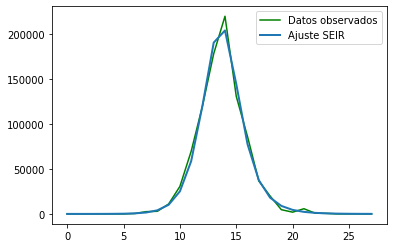

In [ ]:
plt.plot(Ydat, '-g',label='Datos observados')
plt.plot(final, '-', linewidth=2,label='Ajuste SEIR');
plt.legend()
plt.show()

In [ ]:
be_0=result.params['be'].value
la_0=result.params['la'].value
ga_0=result.params['ga'].value
x0=[be_0,la_0,ga_0]#Primer propuesta de la cadena en pytwalk()
print(x0)

[2.5242575167008976, 2.816105657967901, 0.9439395288082381]


In [ ]:
par1=[be_0,0,1]  #hiperparametros para beta
par2=[la_0,0,1]  #hiperparametros para lamba
par3=[ga_0,0,1]  #hiperparametros para gamma

def logaprioris(theta):
    be,la,ga = theta
    dbe = scipy.stats.gamma.logpdf(be,par1[0],par1[1],par1[2])
    dla = scipy.stats.gamma.logpdf(la,par2[0],par2[1],par2[2])
    dga = scipy.stats.gamma.logpdf(ga,par3[0],par3[1],par3[2])
    return(dbe+dla+dga)

Visualización de las distribuciones a prior. Utilizaremos distribuciones Gamma por simplicidad, pues satisfacen que su soporte es $(0,\infty)$, y podemos controlar el valor de su media fácilmente a través de sus parámetros.

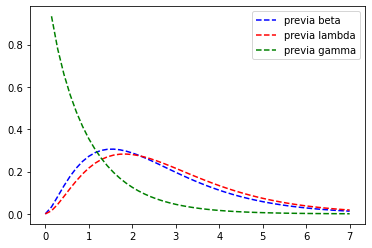

In [ ]:
x = np.linspace(0., 7, 50)
prev1 = scipy.stats.gamma.pdf(x, par1[0],par1[1],par1[2])
prev2 = scipy.stats.gamma.pdf(x, par2[0],par2[1],par2[2])
prev3 = scipy.stats.gamma.pdf(x, par3[0],par3[1],par3[2])
plt.plot(x, prev1, 'b--', label='previa beta')
plt.plot(x, prev2, 'r--', label='previa lambda')
plt.plot(x, prev3, 'g--', label='previa gamma')
plt.legend(loc="best")

Buscamos numéricamente un mínimo local de la función de -log(Verosimilitud), para segunda propuesta de la cadena. 

In [ ]:
#Segundo intento. Optimizacion numérica sobre la funcion de verosimilitud
from scipy.optimize import minimize
def menosloglikelihood(theta):
    return -logverosimilitud(theta)
bnds = ((0.01, 10), (0.01, 6.0),(0.01, 6.0))
xp0=minimize(fun=menosloglikelihood,x0=[be_0,la_0,ga_0],bounds=bnds).x#Segundo valor de la cadena en pytwalk()


# Metropolis Hastings

In [ ]:
np.random.seed(1)
t=np.arange( 0,len(Ydat)+1,1 )
t0=t[0:28]
I0=1
Y0=1
X0=np.array( [N-I0, 150, I0 ,Y0, 0] )#
T=int(1e5) #iterations
bi=int(0.15* T)#calentamiento
